In [610]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')

In [611]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The code for this notebook is hidden for easier reading.
To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

# Data Cleaning

**Data:** [New York Crime Data - 2013](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)

In [612]:
path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime = pd.read_csv(path)

In [613]:
pd.options.mode.chained_assignment = None

crime.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']
crime.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
crime.drop(labels=['city','rape_revised'],axis=1,inplace=True)

columns = list(crime.columns)
for column in columns:
     crime[column]=crime[column].str.replace(',','')

crime = crime.apply(pd.to_numeric)
crime = crime.dropna()

**Original Target:** 'violent_crime'

**Original Features:** 'aggravated_assault', 'arson', 'burglary', 'larceny_theft', 'murder', 'population', 'rape_legacy', 'vehicle_theft'

In [614]:
crime.head()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
4,1861,0,0,0,0,0,12,2,10,0,0.0
5,2577,3,0,0,0,3,24,3,20,1,0.0
6,2846,3,0,0,0,3,16,1,15,0,0.0
10,1781,3,0,0,0,3,10,0,10,0,0.0
11,118296,107,1,7,31,68,2118,204,1882,32,3.0


In [615]:
crime.describe()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,14787.053476,45.978610,0.566845,2.192513,16.556150,26.663102,339.823529,65.037433,260.871658,13.914439,1.871658
std,27220.701187,201.362989,3.552914,9.124901,81.476501,109.234772,965.182269,242.693164,675.898585,57.360520,10.693411
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2195.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.500000,3.000000,16.000000,0.000000,0.000000
50%,6487.000000,4.000000,0.000000,0.000000,1.000000,3.000000,73.000000,11.000000,62.000000,2.000000,0.000000
75%,16109.000000,17.000000,0.000000,1.000000,4.000000,11.000000,297.000000,39.000000,240.500000,5.000000,1.000000
max,210562.000000,2107.000000,42.000000,92.000000,918.000000,1055.000000,10051.000000,2587.000000,6855.000000,609.000000,132.000000


## Dealing With 'population'

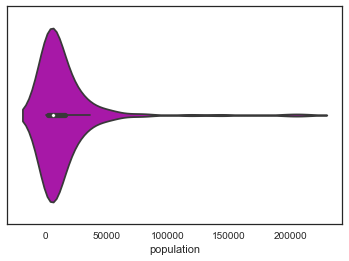

In [616]:
population = sns.violinplot(crime['population'], color='m')

**'population' has outliers that can seriously bias/influence inter-feature and feature-target relationships. I eliminated them by setting an upper limit at: $$75th Percentile + [1.5*IQR]$$.**

In [617]:
q25 = crime['population'].quantile(0.25)
q75 = crime['population'].quantile(0.75)
iqr = q75 - q25
maximum = q75 + (iqr * 1.5)
crime=crime.where(crime['population'] < maximum)

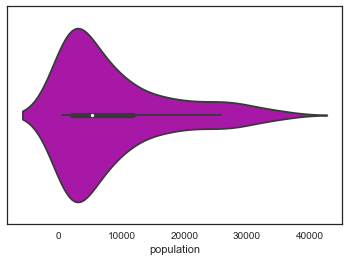

In [618]:
population = sns.violinplot(crime['population'], color='m')

## Feature-Target Relationships

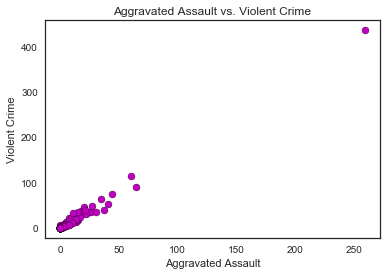

In [619]:
plt.scatter(y=crime['violent_crime'], x=crime['aggravated_assault'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Aggravated Assault')
plt.title('Aggravated Assault vs. Violent Crime')
plt.show()

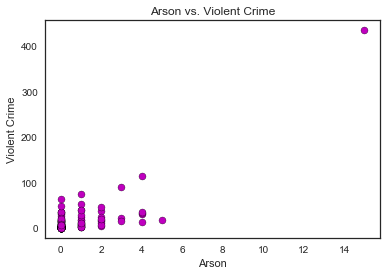

In [620]:
plt.scatter(y=crime['violent_crime'], x=crime['arson'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Arson')
plt.title('Arson vs. Violent Crime')
plt.show()

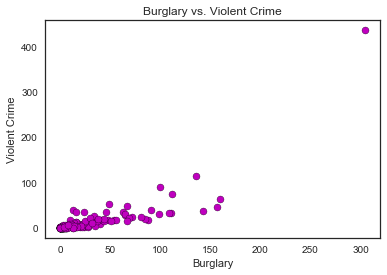

In [621]:
plt.scatter(y=crime['violent_crime'], x=crime['burglary'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Burglary')
plt.title('Burglary vs. Violent Crime')
plt.show()

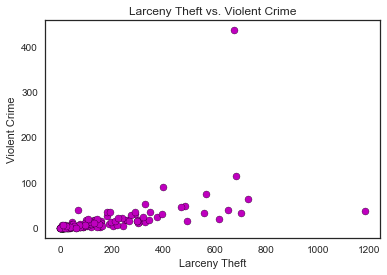

In [622]:
plt.scatter(y=crime['violent_crime'], x=crime['larceny_theft'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Larceny Theft')
plt.title('Larceny Theft vs. Violent Crime')
plt.show()

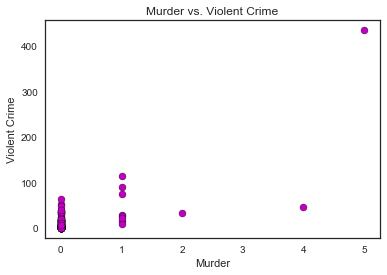

In [623]:
plt.scatter(y=crime['violent_crime'], x=crime['murder'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Murder')
plt.title('Murder vs. Violent Crime')
plt.show()

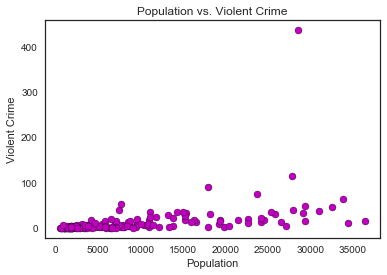

In [624]:
plt.scatter(y=crime['violent_crime'], x=crime['population'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Population')
plt.title('Population vs. Violent Crime')
plt.show()

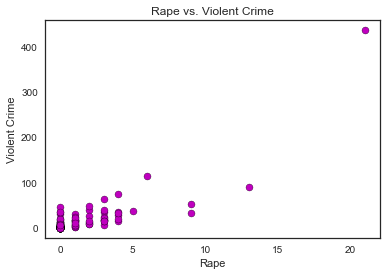

In [625]:
plt.scatter(y=crime['violent_crime'], x=crime['rape_legacy'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Rape')
plt.title('Rape vs. Violent Crime')
plt.show()

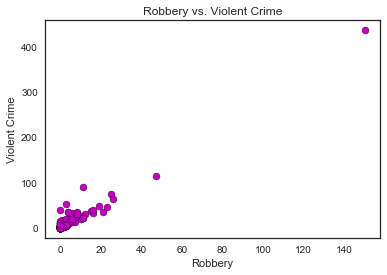

In [626]:
plt.scatter(y=crime['violent_crime'], x=crime['robbery'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Violent Crime')
plt.show()

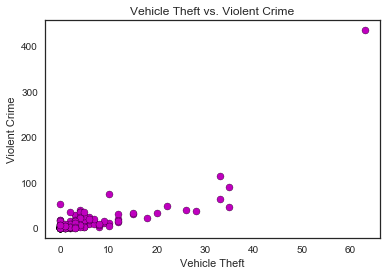

In [627]:
plt.scatter(y=crime['violent_crime'], x=crime['vehicle_theft'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Vehicle Theft')
plt.title('Vehicle Theft vs. Violent Crime')
plt.show()

# Feature Engineering

## Original Correlation Matrix

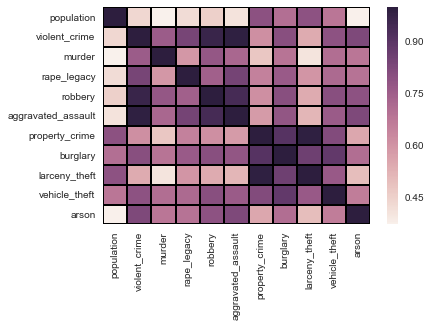

In [628]:
correlations = sns.heatmap(crime.corr(),linewidths=1,linecolor='black')

**Because 'population' is causing feature multicollinearity, I rescaled on a per capita basis by dividing it by 1000 and then dividing the others by it.**

In [629]:
crime['population'] = crime['population'].apply(lambda x: x/1000)
features = crime[['violent_crime','murder','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']]
feature_columns = list(features.columns)
for column in feature_columns:
    crime[column] = crime[column].apply(lambda x: x/crime['population'])
crime = crime.dropna()

In [630]:
crime.head()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
4,1.861,0.000000,0.0,0.000000,0.000000,0.000000,6.448146,1.074691,5.373455,0.000000,0.000000
5,2.577,1.612037,0.0,0.000000,0.000000,1.612037,12.896292,1.612037,10.746910,0.537346,0.000000
6,2.846,1.612037,0.0,0.000000,0.000000,1.612037,8.597528,0.537346,8.060183,0.000000,0.000000
10,1.781,1.612037,0.0,0.000000,0.000000,1.612037,5.373455,0.000000,5.373455,0.000000,0.000000
12,9.519,4.836110,0.0,1.074691,2.149382,1.612037,112.842558,8.597528,101.020956,3.224073,0.537346


In [631]:
crime.describe()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,8.736372,6.548117,0.059358,0.477988,1.899454,4.111318,83.266686,12.758832,68.355348,2.152506,0.274921
std,8.848373,19.518755,0.293170,1.260456,6.804242,11.697474,119.061364,20.687394,97.235937,4.316598,0.789324
min,0.526000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.053750,0.403009,0.000000,0.000000,0.000000,0.000000,9.537883,1.612037,7.388501,0.000000,0.000000
50%,5.261500,1.612037,0.000000,0.000000,0.000000,1.074691,31.972058,4.567437,25.523912,0.537346,0.000000
75%,11.840750,6.716819,0.000000,0.537346,1.612037,4.298764,103.976357,15.314347,85.303600,2.149382,0.000000
max,36.369000,233.745298,2.686728,11.284256,80.601827,139.172488,727.028479,163.353036,635.142397,33.852767,8.060183


### Additional Feature 1: 'violent_crime_recoded'

In [632]:
crime['violent_crime_recoded']=crime['violent_crime'].apply(lambda x: 1 if x > crime['violent_crime'].quantile(0.50) else 0)

#### Checking Class Balance

In [633]:
crime['violent_crime_recoded'].value_counts()

0    92
1    80
Name: violent_crime_recoded, dtype: int64

### Additional Feature 2: 'arson_squared'

In [634]:
crime['arson_squared']=crime['arson']**2

#### Checking Feature-Target Relationship 

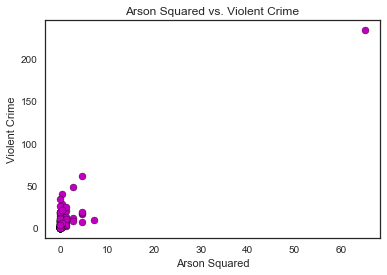

In [635]:
plt.scatter(y=crime['violent_crime'], x=crime['arson_squared'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Arson Squared')
plt.title('Arson Squared vs. Violent Crime')
plt.show()

### Additional Feature 3: 'murder_squared'

In [636]:
crime['murder_squared']=crime['murder']**2

#### Checking Feature-Target Relationship 

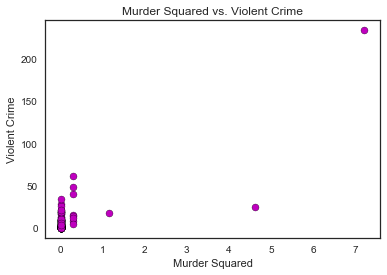

In [637]:
plt.scatter(y=crime['violent_crime'], x=crime['murder_squared'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Murder Squared')
plt.title('Murder Squared vs. Violent Crime')
plt.show()

### Additional Feature 4: 'rape_squared'

In [638]:
crime['rape_squared']=crime['rape_legacy']**2

#### Checking Feature-Target Relationship 

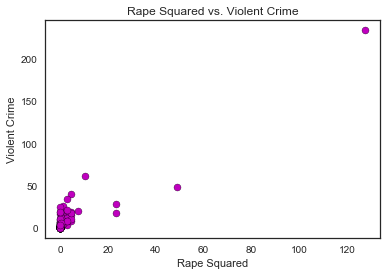

In [639]:
plt.scatter(y=crime['violent_crime'], x=crime['rape_squared'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Rape Squared')
plt.title('Rape Squared vs. Violent Crime')
plt.show()

### Additional Feature 5: 'sum_theft'

In [640]:
crime['sum_theft'] = crime['burglary']+crime['larceny_theft']+crime['vehicle_theft']

#### Checking Feature-Target Relationship 

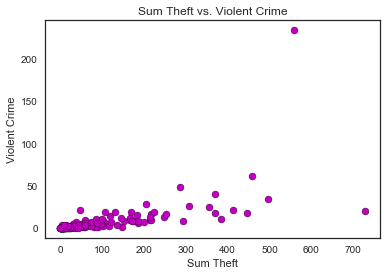

In [641]:
plt.scatter(y=crime['violent_crime'], x=crime['sum_theft'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Sum Theft')
plt.title('Sum Theft vs. Violent Crime')
plt.show()

### Additional Feature 6: 'sum_violence'

In [642]:
crime['sum_violence'] = crime['aggravated_assault']+crime['arson']+crime['rape_legacy']+crime['robbery']

#### Checking Feature-Target Relationship 

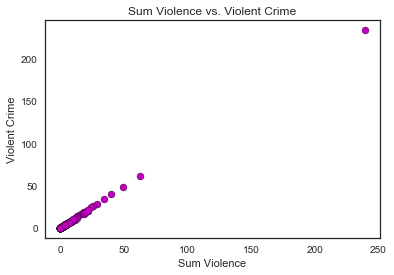

In [643]:
plt.scatter(y=crime['violent_crime'], x=crime['sum_violence'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Sum Violence')
plt.title('Sum Violence vs. Violent Crime')
plt.show()

### Additional Feature 7: violent_theft'

In [644]:
crime['violent_theft'] = crime['sum_theft']*crime['sum_violence']

#### Checking Feature-Target Relationship 

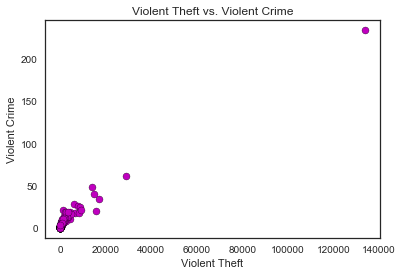

In [645]:
plt.scatter(y=crime['violent_crime'], x=crime['violent_theft'],c='m',edgecolors='k')
plt.ylabel('Violent Crime')
plt.xlabel('Violent Theft')
plt.title('Violent Theft vs. Violent Crime')
plt.show()

## Revised Correlation Matrix

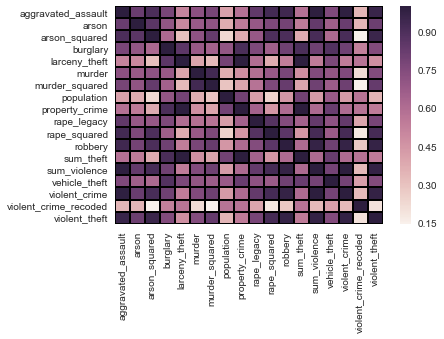

In [646]:
order = list(crime.columns)
reorder=[5,10,12,7,8,2,13,0,6,3,14,4,15,16,9,1,11,17]
order = [ order[i] for i in reorder]
crime = crime[order]
correlations = sns.heatmap(crime.corr(),linewidths=1,linecolor='k')

**Model comparison would've been difficult if I'd used checking assumptions as a basis for preliminary feature exclusion/selection. I retained them all.**

# Binary  Logistic Regression

In [647]:
crime = crime.replace([np.inf, -np.inf], np.nan).dropna(how="all")
X = crime[['aggravated_assault','arson','arson_squared','burglary','larceny_theft','murder','murder_squared','population','rape_legacy','rape_squared','robbery','sum_theft','sum_violence','vehicle_theft','violent_theft']]
Y = crime['violent_crime_recoded']
blr = LogisticRegression(C=1e9)
fit = blr.fit(X, Y)
scores_blr = cross_val_score(blr, X, Y, cv=5)
score_blr = cross_val_score(blr, X, Y, cv=5).mean()
print('Coefficients: {}\n'.format(blr.coef_))
print('Cross-Validation Scores: {}\n'.format(scores_blr))
print('Average of Cross-Validation Scores Across Folds: {:.2%}.\n'.format(score_blr))

Coefficients: [[ -2.44648810e-01  -1.49069738e-02  -7.97972193e-03  -1.67859866e-01
   -9.93230870e-01   4.17371329e-05   2.24375072e-05  -3.93813846e-01
    9.36344634e-04   5.37942144e-04   2.41209784e-01  -1.11793589e+00
   -1.74096545e-02   4.31548446e-02   1.12542758e+00]]

Cross-Validation Scores: [ 1.          1.          0.97058824  1.          1.        ]

Average of Cross-Validation Scores Across Folds: 99.41%.



## Model Interpretation

In [648]:
blr_coefficients = pd.DataFrame(blr.coef_)
factors = blr_coefficients.apply(lambda x: math.exp(x))
print(factors)

0     0.782979
1     0.985204
2     0.992052
3     0.845472
4     0.370378
5     1.000042
6     1.000022
7     0.674480
8     1.000937
9     1.000538
10    1.272788
11    0.326954
12    0.982741
13    1.044100
14    3.081534
dtype: float64


**Given that Binary Logistic Regression doesn't leverage regularization parameters to minimize the cost function in ways that control overfitting and select features, it doesn't surprise me that 80% of the cross-validation folds have a perfect R-Square score.** 

**Based on a back-transformation of the log-odds, the following features increase the odds of a violent crime being committed by a factor of:**
- 'aggravated_assault': 0.78
- 'arson': 0.99
- 'arson_squared': 0.99
- 'burglary': 0.85
- 'larceny_theft': 0.37
- 'murder': 1.00
- 'murder_squared': 1.00
- 'population': 0.67
- 'rape_legacy': 1.00
- 'rape_squared': 1.00
- 'robbery': 1.27
- 'sum_theft': 0.33
- 'sum_violence': 0.98
- 'vehicle_theft': 1.04
- 'violent_theft': 3.08

**These factors reflect the consequences of some of the feature engineering decisions I made.**

# Ridge Logistic Regression

In [649]:
lambdas = [1,5,10,20]
for lambd in lambdas:
    X = crime[['aggravated_assault','arson','arson_squared','burglary','larceny_theft','murder','murder_squared','population','rape_legacy','rape_squared','robbery','sum_theft','sum_violence','vehicle_theft','violent_theft']]
    Y = crime['violent_crime']
    rr = linear_model.Ridge(alpha=lambd, fit_intercept=False) 
    fit = rr.fit(X, Y)
    scores_rr = cross_val_score(rr, X, Y, cv=5)
    score_rr = cross_val_score(rr, X, Y, cv=5).mean()
    print('Lambda: {}.\n'.format(lambd))
    print('Coefficients: {}\n'.format(rr.coef_))
    print('Cross-Validation Scores: {}\n'.format(scores_rr))
    print('Averaged Cross-Validation Scores: {:.2%}.\n'.format(score_rr))

Lambda: 1.

Coefficients: [  3.77305025e-01  -5.13531084e-01  -3.68295081e-02   5.33541103e-04
   7.89053843e-04   5.46009465e-01   2.06424188e-01   1.24050185e-03
   3.68764296e-01   5.14088394e-03   3.87563876e-01  -9.54017921e-04
   6.20102114e-01  -2.27661293e-03   5.05417578e-06]

Cross-Validation Scores: [ 0.99998365  0.99992882  0.99998145  0.99999017  0.9998798 ]

Averaged Cross-Validation Scores: 100.00%.

Lambda: 5.

Coefficients: [  3.54635356e-01  -3.66284031e-01  -8.90097061e-02   3.12727373e-03
   1.34453642e-03   2.64582314e-01   2.62050327e-01   3.99572090e-03
   2.76933152e-01   1.88648985e-02   3.72254750e-01  -1.97484024e-03
   6.37539227e-01  -6.44665040e-03   2.03585487e-05]

Cross-Validation Scores: [ 0.999888    0.99959734  0.9998135   0.99979735  0.99898947]

Averaged Cross-Validation Scores: 99.96%.

Lambda: 10.

Coefficients: [  3.44891785e-01  -2.78985631e-01  -1.15486523e-01   5.02618844e-03
   1.00490895e-03   1.86197585e-01   2.27247515e-01   5.87787764e-0

## Model Interpretation

**Ridge Logistic Regression is an improvement over Binary Logistic Regression, given the fact that all of the data in the former is continuous (as opposed to using continuous features to predict a categorical target for which class imbalance is a concern). It also addresses feature multcollinearity using L2 regularization. As alpha/lambda increase, the coefficient inflation control effect becomes more pronounced - they increase/decrease/hold constant within their order of magnitude. In parallel, the R-Squared scores only decrease by hundredths of a percent.** 

# Lasso Logistic Regression

In [650]:
lambdas = [1,5,10,20]
for lambd in lambdas:
    X = crime[['aggravated_assault','arson','arson_squared','burglary','larceny_theft','murder','murder_squared','population','rape_legacy','rape_squared','robbery','sum_theft','sum_violence','vehicle_theft','violent_theft']]
    Y = crime['violent_crime']
    lr = linear_model.Lasso(alpha=lambd, fit_intercept=False) 
    fit = lr.fit(X, Y)
    scores_lr = cross_val_score(lr, X, Y, cv=5)
    score_lr = cross_val_score(lr, X, Y, cv=5).mean()
    print('Lambda: {}.\n'.format(lambd))
    print('Coefficients: {}\n'.format(lr.coef_))
    print('Cross-Validation Scores: {}\n'.format(scores_lr))
    print('Averaged Cross-Validation Scores: {:.2%}.\n'.format(score_lr))

Lambda: 1.

Coefficients: [  0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -7.36381894e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   7.59437218e-03
   9.06440921e-01   0.00000000e+00   1.17710156e-04]

Cross-Validation Scores: [ 0.99613461  0.98645393  0.9979665   0.99855355  0.99625292]

Averaged Cross-Validation Scores: 99.51%.

Lambda: 5.

Coefficients: [  0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   7.53926264e-03
   6.67987284e-01   0.00000000e+00   5.27014199e-04]

Cross-Validation Scores: [ 0.95466114  0.97678633  0.98384055  0.99029748  0.98702154]

Averaged Cross-Validation Scores: 97.85%.

Lambda: 10.

Coefficients: [ 0.          0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.01536271

## Model Interpretation

**I favor Lasso Logistic Regression because it simultaneously creates overfitting-protection through shrinkage and  sparsity through feature exclusion/selection using L1 regularization. With the knowledge of how the feature engineeering decisions I made likely compounded multicollinearity and/or obscured actual feature-target relationships, I'm more inclined to trust this model over the others. It retained them all at alpha/lambda = 1 and 5, but only retained the following features at alpha/lambda = 10 and 20:**
- 'sum_theft' (Both)
- 'sum_violence' (10 Only)
- 'violent_theft' (20 Only)

**Interestingly, these were my 3 composite features.**